# Powerprice and Wind Modeling

In [11]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models import OrnsteinUhlenbeck
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, WindPowerForecastModelParameter, MultiRegionWindForecastModel, LinearDemandForwardModel

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation of Powerprices and Wind

In [31]:
params = WindPowerForecastModelParameter(n_call_strikes=40, min_strike=-7.0, max_strike=7.0)
# setup 
wind_region_model = {}
vols = [1.0]
mean_reversion_speed = [0.5]
capacities = [10_000.0]
rnd_weights = [ [1.0]
              ]
np.random.seed(42)
regions = []
for i in range(len(vols)):
    model = WindPowerForecastModel(region='Region_' + str(i), 
                                            speed_of_mean_reversion=mean_reversion_speed[i],
                                            volatility=vols[i], params=params)
    regions.append(MultiRegionWindForecastModel.Region( 
                                    model,
                                    capacity=capacities[i],
                                    rnd_weights=rnd_weights[i]
                                ) )
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [37]:
highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.5, mean_reversion_level=0.0)
model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                    highest_price_ou_model= highest_price, 
                                    power_name= 'Power_Germany')

In [41]:
timegrid = np.linspace(0.0,1.0, 365)
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(10_000, timegrid.shape[0]))
results = model.simulate(timegrid, rnd, expiries=[1.0], 
                         power_fwd_prices=[1.0],
                         initial_forecasts={'Region_0': [0.8]})

In [44]:
print('Keys of simulated values: ', results.keys())
simulated_wind = results.get('Wind_Germany_FWD0')
simulated_power = results.get('Power_Germany_FWD0')
print('final mean power price: ',simulated_power[-1,:].mean() )

Keys of simulated values:  {'Wind_Germany_FWD0', 'Region_0_FWD0', 'Power_Germany_FWD0'}
final mean power price:  0.43953416507891396


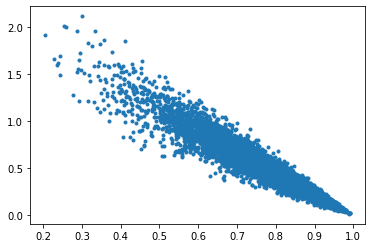

In [43]:
timepoint = 180
plt.plot(simulated_wind[-1,:], simulated_power[-1,:],'.')

In [45]:
results._additive_correction

array([1.83939721])